# machine learning
- first parts are almost same as demo2

In [1]:
import sys
import numpy as np
import pandas as pd
import joblib
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

import chainer
from chainer import cuda
chainer.global_config.autotune = True 

sys.path.append("../MIGraph/GraphConv/")
sys.path.append("../MIGraph/Train/")
sys.path.append("../MIGraph/Encoders/")

from GGNN import GGNN
from Config import Config
from AutoParameterScaling import AutoParameterScaling
from GraphNNPredictor import GraphNNPredictor,formatDataset,myConcat
from PrepDataset import PrepDataset


CF=Config()


/home/kh/anaconda3/envs/chem/lib/python3.6/site-packages/chainer/_environment_check.py:73: UserWarning: 
--------------------------------------------------------------------------------
CuPy (cupy) version 6.0.0 may not be compatible with this version of Chainer.
Please consider installing the supported version by running:
  $ pip install 'cupy>=7.2.0,<8.0.0'

See the following page for more details:
  https://docs-cupy.chainer.org/en/latest/install.html
--------------------------------------------------------------------------------

  requirement=requirement, help=help))


In [2]:
#load dataset
alldataset= joblib.load("bin/traindataset.bin")

#remove graphs with only one node
_,adj,_,_=zip(*alldataset)
delIndexList=[i[0].shape for i in adj]
delIndexList=[True if i[0]==1 else False for i in delIndexList]
alldataset=[data for data,flg in zip(alldataset,delIndexList) if flg!=True]

#for faster learning, minibatch was set to be 128
miniBatch=128

SPL_RATIO=0.8



# utility funcs for ML

In [3]:
from chainer.iterators import SerialIterator

def prepDataset():
    global trainDataset, testDataset
    split_at = int(len(alldataset) * SPL_RATIO)

    trainDataset, testDataset = chainer.datasets.split_dataset_random(alldataset, split_at)

    global train_iter,test_iter
    train_iter= SerialIterator(formatDataset(trainDataset), miniBatch)
    test_iter = SerialIterator(formatDataset(testDataset),1,False,False)

    print("test: ",len(testDataset))
    print("train: ",len(trainDataset))

    #get labels for prediction
    _,_,_,learnLabels=zip(*alldataset)
    #print("params:", list(set(learnLabels)))

In [4]:
#set up model
from chainer import optimizers
from chainer import training
from chainer.training import extensions
from chainer import serializers

def train():
    global ggnn
    ggnn=GraphNNPredictor()

    if CF.GPUMode:
        cuda.get_device(CF.gpu_device).use()
        ggnn.to_gpu(CF.gpu_device)
        print("gpu mode")

    #optimizer
    optimizer = optimizers.Adam()
    optimizer.setup(ggnn)
    updater = training.updaters.StandardUpdater(train_iter, optimizer, device=CF.gpu_device,converter=myConcat)

    #trainer (early stopping can be used, but 100 epoch is good)
    max_epoch = 100

    #ML seems much faster without validation (at least, in author's environment)
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='res')
    trainer.extend(extensions.LogReport())
    #trainer.extend(extensions.Evaluator(test_iter, ggnn, device=CF.gpu_device))
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss',  'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss','validation/main/loss'], x_key='epoch', file_name='loss.png'))

    trainer.run()



# train

In [5]:
prepDataset()
train()

test:  5025
train:  20097
gpu mode
epoch       main/loss   validation/main/loss  elapsed_time
1           1.25161                           4.97678       
2           0.921397                          9.51045       
3           0.732633                          13.9884       
4           0.629037                          18.4989       
5           0.560148                          22.9833       
6           0.523189                          27.4754       
7           0.485724                          31.9911       
8           0.46501                           36.4774       
9           0.448139                          40.9755       
10          0.425827                          45.4983       
11          0.416259                          49.9782       
12          0.402329                          54.4914       
13          0.387912                          58.9772       
14          0.379247                          63.4638       
15          0.357612                          67.979

# check the predicted results (of training datasets)

In [6]:
# let's check how words are predicted

from AnalyzeUtility import AnalyzeUtility

AutoSC=joblib.load("praparingGraphs/output/AutoSC.scaler")
PD= joblib.load("bin/PD.bin")
analUtil=AnalyzeUtility(AutoSC,ggnn)

testYPred,testY=analUtil.predictByGGNN_batch(formatDataset(testDataset))
trainYPred,trainY=analUtil.predictByGGNN_batch(formatDataset(trainDataset))

targetDB=trainDataset
YPred=trainYPred

100%|██████████| 629/629 [00:05<00:00, 115.85it/s]


In [7]:
# from prediction (as a vetor), search the most similar word in a database
def searchWord(targetvec):
    cosSimList=np.dot(wordVecList,targetvec)/(np.linalg.norm(targetvec)* (np.linalg.norm(wordVecList,axis=1)))
    predList=[[i,j] for i,j in zip(list(PD.ALE.OE.vecDict.keys()),cosSimList)]
    predList.sort(key=lambda x: x[1],reverse=True)
    return predList[0][0]
    
def cleanWord(w):
    clList=[ "[",   "]" ,"3" ,"10","(",")","-","6","0" ]
    w=w.replace("empty"," ")
    for cl in clList:
        w=w.replace(cl,"")
    
    w="" if w ==" " else w
    return w

# let's see how words were predicted

In [8]:
_,_,_,ansList=zip(*targetDB)

# there are three types of problems (compound, values, and others (words))
typeList=[]
for i in ansList:
    if type(i) ==type(""):
        if i[:2]=="C_":
            typeList.append("C")
        else:
            typeList.append("O")
    else:
        typeList.append("V")


# extract the cases of word prediction problems
wordFilter=[True if i=="O" else False for i in typeList]
wordVecList=list(PD.ALE.OE.vecDict.values())
ansWordList=[ans for ans,filt in zip(ansList,wordFilter) if filt]
predWordList=[searchWord(vec) for vec,filt in zip(YPred,wordFilter) if filt]

predWordList=[cleanWord(i) for i in predWordList]
ansWordList=[cleanWord(i) for i in ansWordList]
print(len(predWordList), "types of word problems")

wrongList=[(i,j) for i,j in zip(predWordList,ansWordList) if i!=j]

#compare actual and predicted words
pd.DataFrame(wrongList)


12657 types of word problems


,0,1
0,decomposition temperature,boiling temperature
1,absolute molar magnetic susceptibility,molar heat capacity
2,mol/l,kj/mol
3,pedot_pss_ph,pedot_pss_agfa gevaert
4,melting temperature,boiling temperature
...,...,...
1593,decomposition temperature,melting temperature
1594,absolute molar magnetic susceptibility,absolute standard enthalpy of formation
1595,refractive index,partition coefficient
1596,absolute molar magnetic susceptibility,absolute standard enthalpy of formation


# let's see how numeric values were predicted

20097it [00:00, 469397.12it/s]


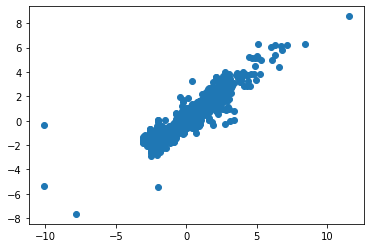

In [9]:
valFilter=[True if i=="V" else False for i in typeList]
ansValList=[ans for ans,filt in zip(ansList,valFilter) if filt]
predValList=[np.mean(vec) for vec,filt in tqdm(zip(YPred,valFilter)) if filt]
plt.plot(ansValList,predValList,"o")

# let's see how compounds were predicted

In [10]:
from rdkit import Chem
from rdkit.Chem import AllChem

compVecList=PD.ALE.CE.CompDat.compVecList

# search most similar compound in a compound database
def searchComp(targetvec, singleMode=True):
    cosSimList=np.dot(compVecList,targetvec)/(np.linalg.norm(targetvec)* (np.linalg.norm(compVecList,axis=1)))
    predList=[[i,j] for i,j in zip((PD.ALE.CE.CompDat.IDList),cosSimList)]
    predList.sort(key=lambda x: x[1],reverse=True)

    if singleMode:
        return predList[0][0]
    else:
        return predList

def cleanSMILES(sm):
    m=Chem.MolFromSmiles(sm)
    return Chem.MolToSmiles(m)


In [11]:
compFilter=[True if i=="C" else False for i in typeList]

ansCompList=[ans for ans,filt in zip(ansList,compFilter) if filt]
ansCompList=[ans.replace("C_","") for ans in ansCompList]
actSMILES=[cleanSMILES(PD.ALE.CE.CompDat.IDtoSMILES[i]) for i in ansCompList]

predCompList=[searchComp(vec) for vec,filt in (zip(YPred,compFilter)) if filt]
predSMILES=[cleanSMILES(PD.ALE.CE.CompDat.IDtoSMILES[i]) for i in predCompList]

df=pd.DataFrame([predSMILES, actSMILES]).T
df.columns=["pred","act"]
df

,pred,act
0,C=C(NC(=O)[C@H](NC(=O)[C@@H](Cc1cnc[nH]1)NC(=O...,O=C1NC(=O)C(=O)C(=O)N1
1,Cc1cc(C(=O)O)cc(C(=O)O)c1,C[Si](C)(C)N[Si](C)(C)C
2,C=C(NC(=O)[C@H](NC(=O)[C@@H](Cc1cnc[nH]1)NC(=O...,ClC(Cl)(Cl)[Hg]c1ccccc1
3,O,O
4,[Al],O
...,...,...
2160,O=S(=O)(O)c1ccc(C([Mg])C[Mg])cc1.[Mg]c1sc([Mg]...,O=S(=O)(O)c1ccc(C([Mg])C[Mg])cc1.[Mg]c1sc([Mg]...
2161,[In],CNC(C)=O
2162,[Hg],O
2163,[In],CNC(C)=O


# let's try inverse problems...


In [12]:
#load dataset
scdataset= joblib.load("bin/screendataset.bin")
scYPred,_=analUtil.predictByGGNN_batch(formatDataset(scdataset))

100%|██████████| 1/1 [00:00<00:00, 114.04it/s]


# following would be the compounds which will give a conductivity of 10 (,100, 1000, or 10000) S/cm, and melting point of -15oC
- cosine similarity was calculated between the predicted vector and those in the compound database
- first three candidates are listed
- maximum cosine similariy was only around 0.3, whereas ideally 1. To solve the problem, for instance,...
    - we may need to prepare a larger compound database for searching the candidate compound
    - we may need bigger databases
    - we may need to improve models
    - ...

In [13]:
searchComp(scYPred[0],singleMode=False)[:3]

[['PEDOT_PSS_PH1000', 0.48871901362867565],
 ['PEDOT_PSS_P', 0.48871901362867565],
 ['PEDOT_PSS_PH500', 0.48871901362867565]]

In [14]:
searchComp(scYPred[1],singleMode=False)[:3]

[['P048_P123', 0.39866490819500583],
 ['PEDOT_PSS_PH1000', 0.3737885158637679],
 ['PEDOT_PSS_P', 0.3737885158637679]]

In [15]:
searchComp(scYPred[2],singleMode=False)[:3]

[['PEDOT_PSS_PH1000', 0.7266188437839629],
 ['PEDOT_PSS_P', 0.7266188437839629],
 ['PEDOT_PSS_PH500', 0.7266188437839629]]

In [16]:
searchComp(scYPred[3],singleMode=False)[:3]

[['PEDOT_PSS_PH1000', 0.6111084739162488],
 ['PEDOT_PSS_P', 0.6111084739162488],
 ['PEDOT_PSS_PH500', 0.6111084739162488]]